# Practical work on spectral estimation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import librosa

import pyaudio
import IPython.display as ipd
import os, sys, wave, struct

## 1 Autoregressive process
### 1.1 Synthesis

In [2]:
def create_AR(N, sigma2, coeffs):
    Z = np.random.normal(0, np.sqrt(sigma2), size=N)
    X = [0 for k in range(N)]
    for k in range(N):
        s = 0
        for i in range(len(coeffs)):
            s += coeffs[i]*X[k-i-1] # works fine because X[-1] is zero at the first step (k=0).
        X[k] = s + Z[k]
        
    return X

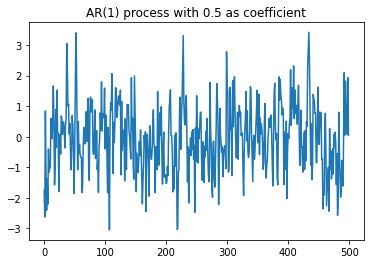

In [3]:
X = create_AR(500, 1, [0.5])
plt.plot(X)
plt.title('AR(1) process with 0.5 as coefficient')
plt.show()

### 1.2 Non parametric estimation : periodogram

In [4]:
def periodogram(X, nu, method='std'):
    X = np.array(X)
    N = len(X)
    exp = np.array([np.exp(-2*1j*np.pi*nu*t) for t in range(1,N+1)])
    
    if method == 'std':
        s = np.sum(X*exp)
        return np.abs(s)**2/N
    M = int(2**np.floor(np.log(N)/np.log(2)-1))
    L = N//M-1
    
    if method == 'Bartlett':
        sum_i = 0
        for i in range(1, L+1):
            sum_t = 0
            for t in range(1, M+1):
                sum_t += X[(i-1)*M + t]*exp[t]
            sum_i += np.abs(sum_t)**2/M
        return sum_i/L
    
    if method == 'Welch':
        w = np.ones(M+1)
        K = M//2
        S = 2*N // M - 1
        P = np.sum(np.abs(w)**2)/N
        sum_i = 0
        for i in range(1, S+1):
            sum_t = 0
            for t in range(M):
                sum_t += w[t-1]*X[(i-1)*K + t]*exp[t]
            sum_i += (np.abs(sum_t)**2/(M*P))
        return sum_i/S

In [5]:
print(periodogram(X, 0.1))
print(periodogram(X, 0.1, 'Bartlett'))
print(periodogram(X, 0.1, 'Welch'))

0.3191057631179885
1.1344990128268067
3.9523966903441434


In [6]:
def display_periodogram(X, coeffs, method='std', sigma2=1):
    nu = np.linspace(-0.5, 0.5, 500)
    per = []
    known_psd = []
    for nu_k in nu:
        per.append(periodogram(X, nu_k, method))
        known_psd.append(sigma2/np.abs(1-coeffs[0]*np.exp(-2*1j*np.pi*nu_k)))
    per = per/max(known_psd)
    #known_psd = known_psd/max(known_psd)
    plt.plot(nu, 20*np.log10(per), label=method)
    plt.plot(nu, 20*np.log10(known_psd), label='theoretical psd')
    plt.legend()
    plt.title(method)
    plt.show()
    if method == 'Welch':
        f, Pxx_den = signal.welch(X, window='bartlett', noverlap=0, nperseg=100, return_onesided=False)
        Pxx_den = Pxx_den/max(known_psd)
        Pxx_den = np.roll(Pxx_den, len(Pxx_den)//2)
        plt.plot(np.roll(f,len(f)//2),20*np.log10(Pxx_den))
        plt.plot(nu, known_psd, label='theoretical psd')
        plt.title('Periodogram with Welch method from scipy signal')
        plt.show()

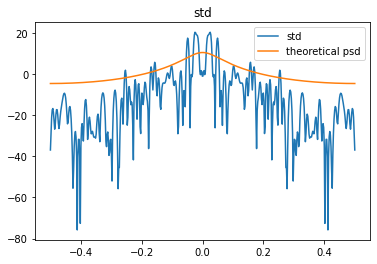

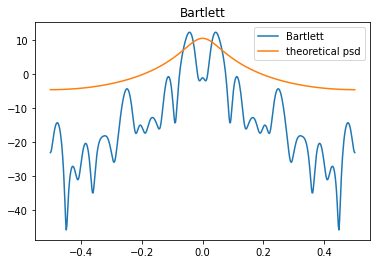

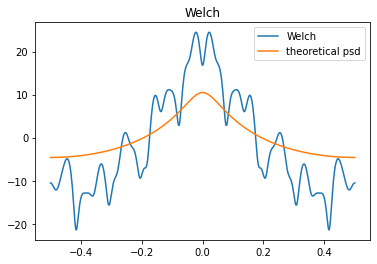

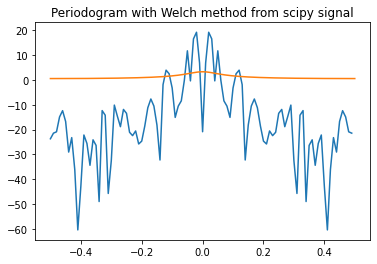

In [7]:
X = create_AR(100, sigma2=1, coeffs=[0.7])
display_periodogram(X, coeffs=[0.7])
display_periodogram(X, coeffs=[0.7], method= 'Bartlett')
display_periodogram(X, coeffs=[0.7], method= 'Welch')

We standardized all those estimated periodograms (divide them by their max value) in order to be able to compare them with the periodogram with the knwon PSD.

In [8]:
methods = ['std', 'Bartlett', 'Welch']

In [9]:
def bias(N, coeffs=[0.5], sigma2=1):
    ksi = np.linspace(-0.5, 0.5, 500)
    X = create_AR(N, sigma2, coeffs)
    
    for method in methods:
        per = []
        known_psd = []
        for ksi_k in ksi:
            per.append(periodogram(X, ksi_k, method))
            known_psd.append(sigma2/np.abs(1-coeffs[0]*np.exp(-2*1j*np.pi*ksi_k)))
        per = per/max(known_psd)
        bias = np.mean(per - known_psd)
        var = np.mean((per - np.mean(per))**2)
        print(f'For {method} method, the computed biais is: {bias}')
        print(f'For {method} method, the computed variance is: {var}\n')
    

In [10]:
bias(100)

For std method, the computed biais is: -0.4415521517617628
For std method, the computed variance is: 0.7975055722791771

For Bartlett method, the computed biais is: -0.37209447731686623
For Bartlett method, the computed variance is: 0.3541784821300118

For Welch method, the computed biais is: 0.9357929185602488
For Welch method, the computed variance is: 3.0129391471306697



It is surprising to see a greater variance for the Welch method compared to the standard one, as the interest of this method is to reduce the variance.

### 1.3 Parametric estimation : linear prediction

In [11]:
X = create_AR(500, 1, [0.5])
print(f'For a signal of length 500 and with a coefficient of 0.5, \
the estimated coeff is {-librosa.lpc(np.array(X), order=1)[1]}\n')

X = create_AR(10000, 1, [0.5])
print(f'For a signal of length 10000 and with a coefficient of 0.5, \
the estimated coeff is {-librosa.lpc(np.array(X), order=1)[1]}\n')

X = create_AR(10000, 1, [-0.9])
print(f'For a signal of length 10000 and with a coefficient of -0.9, \
the estimated coeff is {-librosa.lpc(np.array(X), order=1)[1]}')

For a signal of length 500 and with a coefficient of 0.5, the estimated coeff is 0.48271232474711484

For a signal of length 10000 and with a coefficient of 0.5, the estimated coeff is 0.5055630363815337

For a signal of length 10000 and with a coefficient of -0.9, the estimated coeff is -0.8979932432575211


The estimation of the coefficient for an AR(1) processe is very good for a signal with a sufficient length.

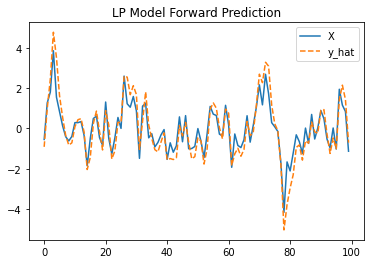

In [12]:
X = create_AR(5000, 1, [0.5]) # high length signal for more precise estimation
b = np.hstack([[1], -librosa.lpc(np.array(X), order=1)[1]])
y_hat = signal.lfilter(b, [1], X)
#plot both signals
plt.plot(X[100:200]) # display a small part for better visualization
plt.plot(y_hat[100:200], linestyle='--')
plt.legend(['X', 'y_hat'])
plt.title('LP Model Forward Prediction')
plt.show()

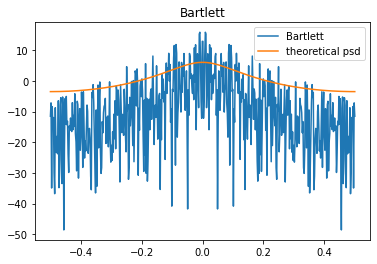

In [13]:
display_periodogram(X, coeffs = [0.5], method = 'Bartlett')

Periodogram of the real sound above and of the estimated signal below:

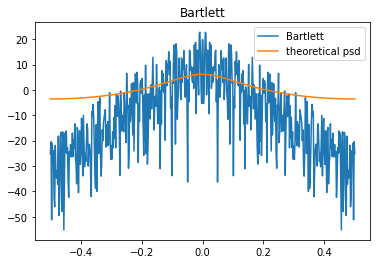

In [14]:
display_periodogram(y_hat, coeffs = [b[1]], method = 'Bartlett')

Comparing the two blue periodograms, we seee that they are very close to each other. What could be said is that the one with the estimated coefficients from Librosa is more concentrated in the lower frequencies, as it looks flatter for higher frequencies.

#### 7 
For this questions, I reused the code from TSIA 202-a

In [15]:
def load_sound(file):
    return wave.open(file, 'rb')

def play_sound(file, chunk = 1024):
    """
    Script from PyAudio doc
    """
    wf = load_sound(file)
    p = pyaudio.PyAudio()
    stream = p.open(format=p.get_format_from_width(wf.getsampwidth()),
                    channels=wf.getnchannels(),
                    rate=wf.getframerate(),
                    output=True)
    data = wf.readframes(chunk)

    while data:
        stream.write(data)
        data = wf.readframes(chunk )

    stream.stop_stream()
    stream.close()
    p.terminate()
      
def plot_sound(data, times, name='default_name', save=False):
    plt.figure(figsize=(30, 4))
    plt.fill_between(times, data)
    plt.xlim(times[0], times[-1])
    plt.xlabel('time (s)')
    plt.ylabel('amplitude')
    if save:
        plt.savefig(name+'.png', dpi=100)
    plt.show()

In [16]:
data_path = os.getcwd()
filename = 'aeiou.wav'
sound = os.path.join(data_path, filename) 

wavefile = load_sound(sound)
print(wavefile.getparams())

_wave_params(nchannels=1, sampwidth=2, framerate=11025, nframes=59964, comptype='NONE', compname='not compressed')


In [17]:
Fs = int(wavefile.getframerate())
num_samples = int(wavefile.getnframes())
data = wavefile.readframes(num_samples)
data = struct.unpack('{n}h'.format(n=num_samples), data)
x = np.array(data)
x = x/32768

# CODE FROM TSIA201
timestep = 1/float(Fs)
times = np.arange(len(x))*timestep

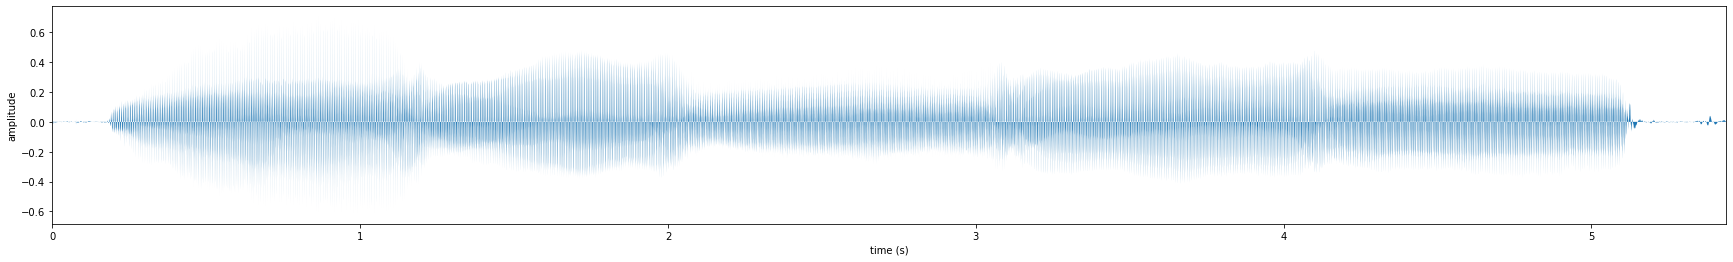

In [18]:
plot_sound(x, times)

In [19]:
#The sound of a is between 0.2 and 1.2s
print(np.argmax(times>0.2))
print(np.argmin(times<1.1))

2206
12128


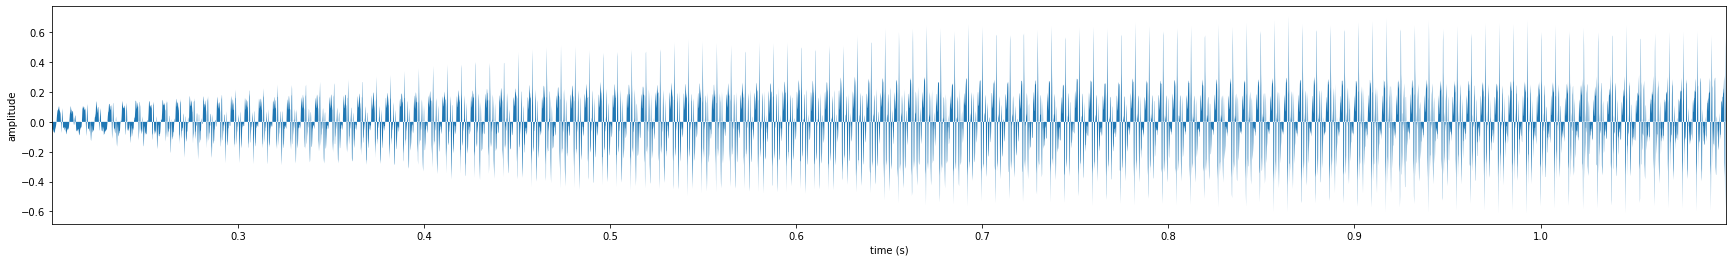

In [20]:
a = x[2206:12128]
time_a = times[2206:12128]
plot_sound(a, time_a)

In [22]:
ipd.Audio(a, rate=11025)

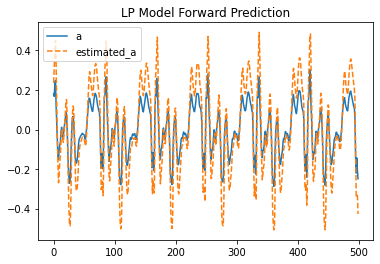

In [23]:
#Make linear prediction
b = np.hstack([[1], -librosa.lpc(np.array(a), order=1)[1]])
y_hat = signal.lfilter(b, [1], a)
#plot both signals
plt.plot(a[1500:2000]) # display a small part for better visualization
plt.plot(y_hat[1500:2000], linestyle='--')
plt.legend(['a', 'estimated_a'])
plt.title('LP Model Forward Prediction')
plt.show()

This estimation of the sound of the vowel a with a AR(1) filter is quite good. The only problem is that the peaks are too high compared to the initial sound 

[0.14788699+1.04353746e-16j 0.14790307+5.23357796e-03j
 0.14795128+1.04669585e-02j ... 0.14795128-1.04669585e-02j
 0.14790307-5.23357796e-03j 0.14788699-1.04353746e-16j]


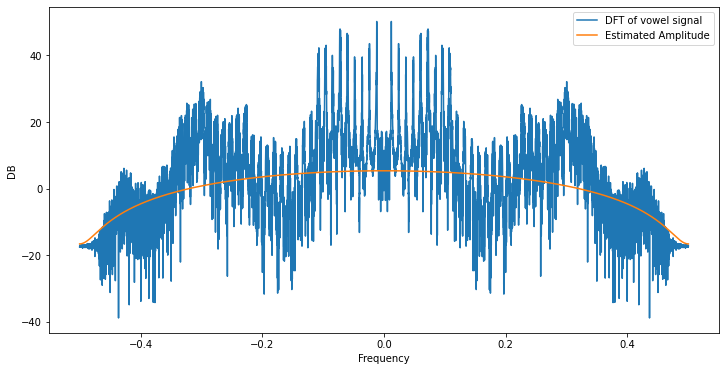

In [24]:
#Spectra comparison
plt.figure(figsize=(12, 6))
nPoints = 1024
nu = np.linspace(-0.5, 0.5 , 1024)
omega = 2*np.pi*nu
w2, H2 = signal.freqz(b,[1], omega)
print(H2)
H2 = abs(H2)

per_a = []

per_a= abs(np.fft.fft(a))
aux2=per_a[int(len(per_a)/2):].copy()
aux2=np.concatenate([aux2, per_a[0:int(len(per_a)/2)]])
freq_a = np.linspace(-0.5, 0.5, len(aux2))
plt.plot(freq_a, 20*np.log10(aux2), label='DFT of vowel signal')
plt.plot(w2/(2*np.pi),20*np.log10(H2), label='Estimated Amplitude')
plt.ylabel('DB')
plt.xlabel('Frequency')
plt.legend()
plt.show()

## 2 Sum of noisy sinusoids

In [15]:
def create_sinusoid(N, K, A, nu, phi, sigma2=1):
    signal = []
    Z = np.random.normal(0, np.sqrt(sigma2), size=N)
    for t in range(N): #length of the signal
        sum = 0
        for k in range(K): #number of sinusoids
            sum += A[k]* np.sin(2*np.pi*nu[k]*t + phi[k])
        signal.append(sum + Z[t])
    return signal, Z

In [16]:
s, noise = create_sinusoid(100, 2, [1,1], [-0.3, 0.2], [0,0])

In [17]:
def display_periodogram_sin(s, nu, method='std', sigma2=1):
    nu_plot = np.linspace(-0.5, 0.5, 500) #frequencies for the plot
    per = []
    for nu_k in nu_plot:
        per.append(periodogram(s, nu_k, method))
    #per = per/max(per)
    plt.vlines(nu, 0,max(per), label='nu_i frequencies',colors='orange')
    plt.plot(nu_plot, per, label=method)
    plt.hlines(sigma2, -0.5, 0.5, colors ='green', linestyle='--', label='white noise PSD')
    plt.legend()
    plt.title(method + ' method')
    plt.show()
    if method == 'Welch':
        f, Pxx_den = signal.welch(s, window='bartlett', noverlap=0, nperseg=100, return_onesided=False)
        #Pxx_den = Pxx_den/max(Pxx_den)
        Pxx_den = np.roll(Pxx_den, len(Pxx_den)//2)
        plt.plot(np.roll(f,len(f)//2),Pxx_den)
        plt.hlines(sigma2, -0.5, 0.5, colors ='green', linestyle='--', label='white noise PSD')
        plt.vlines(nu, 0, max(Pxx_den), label='nu_i frequencies',colors='orange')
        plt.title('Periodogram with Welch method from scipy signal')
        plt.show()

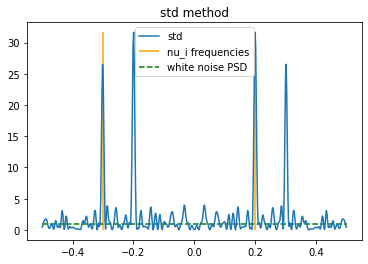

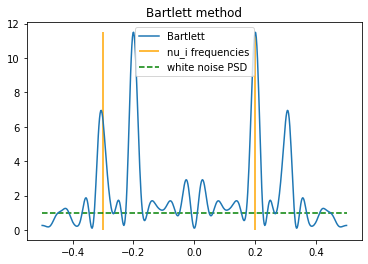

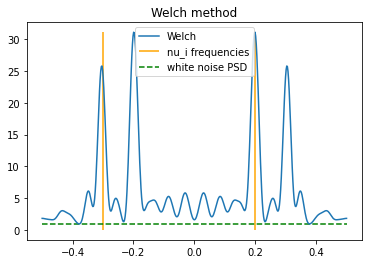

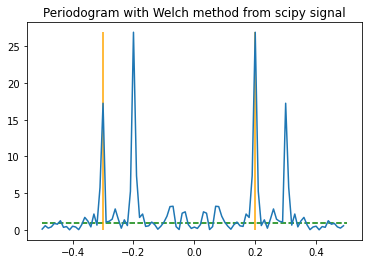

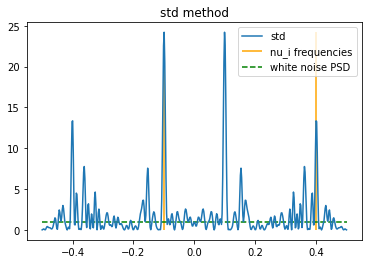

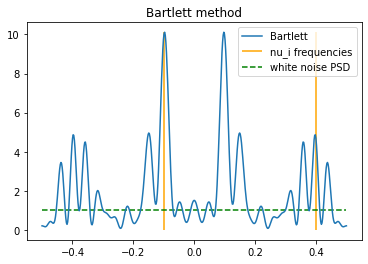

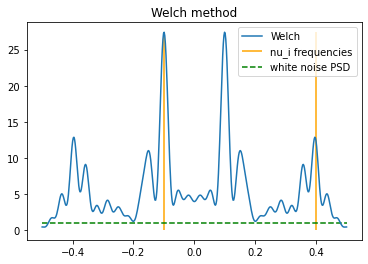

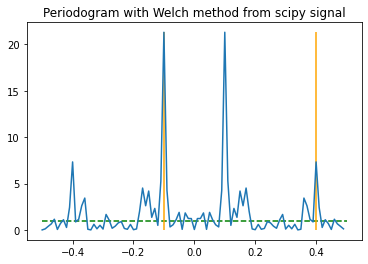

In [18]:
for method in methods: 
    display_periodogram_sin(s, [-0.3, 0.2], method=method) 
s, noise = create_sinusoid(100, 2, [1,1], [-0.1, 0.4], [0,0])
for method in methods: 
    display_periodogram_sin(s, [-0.1, 0.4], method=method) 

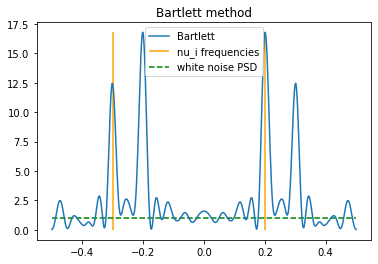

In [19]:
#delta_nu = 0.1 and SNR = 1
s, noise = create_sinusoid(100, 2, [1,1], [-0.3, 0.2], [0,0])
display_periodogram_sin(s, [-0.3, 0.2], method='Bartlett')

Here, delta-nu = 0.1 and SNR = 0 dB (=1).

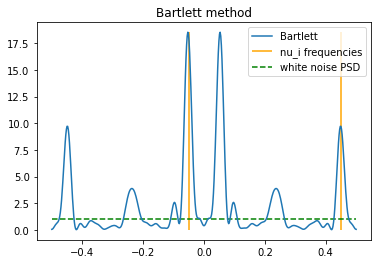

In [20]:
#delta_nu = 0.5 and SNR = 1
s, noise = create_sinusoid(100, 2, [1,1], [-0.05, 0.45], [0,0])
display_periodogram_sin(s, [-0.05, 0.45], method='Bartlett')

Here, delta-nu = 0.5 and SNR = 0 dB (=1).

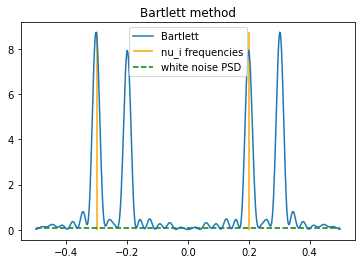

In [21]:
#delta_nu = 0.1 and SNR = 10
s, noise = create_sinusoid(100, 2, [1,1], [-0.3, 0.2], [0,0], sigma2=0.1)
display_periodogram_sin(s, [-0.3, 0.2], method='Bartlett', sigma2=0.1)

Here, delta-nu = 0.1 and SNR = 20dB (=10).

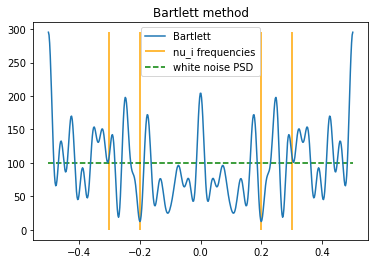

In [22]:
#delta_nu = 0.1 and SNR = 1/100
s, noise = create_sinusoid(100, 2, [1,1], [-0.3, 0.2], [0,0], sigma2=100)
display_periodogram_sin(s, [-0.3, -0.2, 0.2, 0.3], method='Bartlett', sigma2=100)

Here, delta-nu = 0.1 and SNR = -40dB (=1/100).

The spectral resolution seems very affected to the SNR, which is normal because with such a low SNR as -40dB, the signal is almost noise only and it is barely possible to distinguish the peaks at $\nu$ frequencies.\
When $\Delta \nu$ is large (0.5 in the second example), there are many peaks at frequencies other than $\nu_1$ and $\nu_2$, which makes it harder to understand what those two frequencies were. We can still take the four more intense peaks but there are other peaks that get close to the four peaks, even with a reasonnable SNR of 1.

### 2.3 Parametric estimation : linear prediction

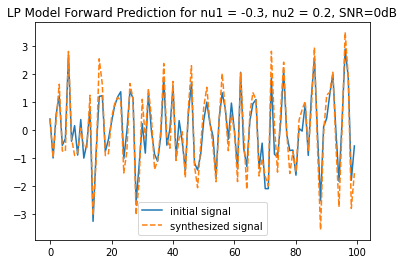

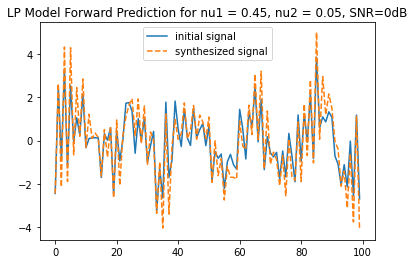

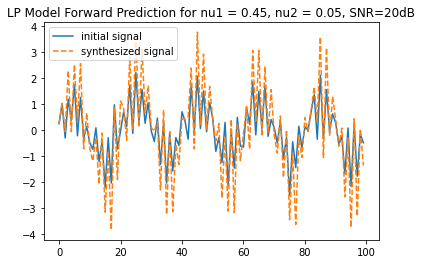

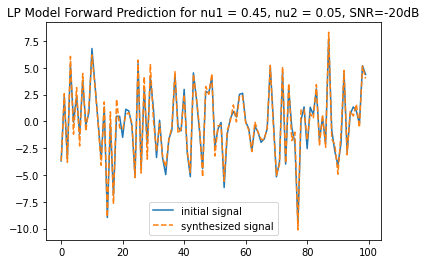

In [23]:
#Fourth order AR estimation
s, noise = create_sinusoid(100, 2, [1,1], [-0.3, 0.2], [0,0])
b = np.hstack([[1], -librosa.lpc(np.array(s), order=4)[1:]])
y_hat = signal.lfilter(b, [1], s)
#plot both signals
plt.plot(s) # display a small part for better visualization
plt.plot(y_hat, linestyle='--')
plt.legend(['initial signal', 'synthesized signal'])
plt.title('LP Model Forward Prediction for nu1 = -0.3, nu2 = 0.2, SNR=0dB')
plt.show()

s, noise = create_sinusoid(100, 2, [1,1], [0.45, 0.05], [0,0])
b = np.hstack([[1], -librosa.lpc(np.array(s), order=4)[1:]])
y_hat = signal.lfilter(b, [1], s)
#plot both signals
plt.plot(s) # display a small part for better visualization
plt.plot(y_hat, linestyle='--')
plt.legend(['initial signal', 'synthesized signal'])
plt.title('LP Model Forward Prediction for nu1 = 0.45, nu2 = 0.05, SNR=0dB')
plt.show()

s, noise = create_sinusoid(100, 2, [1,1], [0.45, 0.05], [0,0], sigma2=0.1)
b = np.hstack([[1], -librosa.lpc(np.array(s), order=4)[1:]])
y_hat = signal.lfilter(b, [1], s)
#plot both signals
plt.plot(s) # display a small part for better visualization
plt.plot(y_hat, linestyle='--')
plt.legend(['initial signal', 'synthesized signal'])
plt.title('LP Model Forward Prediction for nu1 = 0.45, nu2 = 0.05, SNR=20dB')
plt.show()

s, noise = create_sinusoid(100, 2, [1,1], [0.45, 0.05], [0,0], sigma2=10)
b = np.hstack([[1], -librosa.lpc(np.array(s), order=4)[1:]])
y_hat = signal.lfilter(b, [1], s)
#plot both signals
plt.plot(s) # display a small part for better visualization
plt.plot(y_hat, linestyle='--')
plt.legend(['initial signal', 'synthesized signal'])
plt.title('LP Model Forward Prediction for nu1 = 0.45, nu2 = 0.05, SNR=-20dB')
plt.show()

$\Delta \nu$ does not look to have a big influence on the capacity of librosa to estimate the coefficient and make a lienar prediction since the two first plots, with the same SNR and $\Delta \nu$ of 0.1 and 0.5 respectively show similar linear prediction.

The SNR, however, seems to have a great influence on linear prediction. On the one hand, with a low SNR of -10dB, the prediction looks very similar to the initial signal. On the other hand, for a higher SNR of 10, the prediction is far from the signal because it takes too important values (too small when negative and too large when the signal is positive)

### 2.4 Parametric estimation : Capon estimator

In [24]:
#Capon estimator
def r_xx(signal, k):
    N = len(signal)
    sum = 0
    for t in range(N-k):
        sum += signal[t+k]*signal[t]
    return sum

In [25]:
def build_cov_matrix(signal):
    N = len(signal)
    R = np.zeros((N,N))
    for i in range(N):
        for j in range(N):
            R[i,j] = r_xx(signal, np.abs(i-j))
    return R

In [26]:
def capon(signal, nu):
    N = len(signal)
    R = build_cov_matrix(signal)
    exp = np.array([np.exp(-2*1j*np.pi*nu*t) for t in range(N)])
    denominator = np.matrix(exp).getH().T @ np.linalg.inv(R) @ exp
    return N / denominator [0]

In [27]:
def periodogram_capon(signal):
    nu_plot = np.linspace(-0.5, 0.5, 100)
    l = []
    for nu_k in nu_plot:
        l.append(np.real(capon(s, nu_k)).item((0,0)))
    return l

In [56]:
%%time
s, noise = create_sinusoid(100, 2, [1,1], [0.4, 0.1], [0,0], sigma2=1)
l1 = periodogram_capon(s)

Wall time: 52.2 s


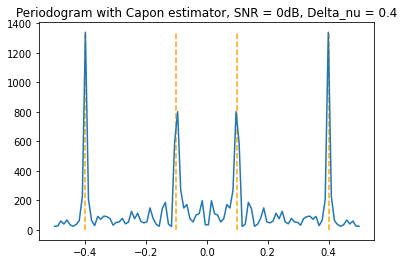

In [57]:
nu_plot = np.linspace(-0.5, 0.5, 100)
plt.plot(nu_plot, l1)
plt.title('Periodogram with Capon estimator, SNR = 0dB, Delta_nu = 0.4')
plt.vlines([-0.4, -0.1, 0.4, 0.1], 0, max(l1), colors='orange', linestyle='--')
plt.show()

In [58]:
%%time
s, noise = create_sinusoid(100, 2, [1,1], [0.13, 0.1], [0,0], sigma2=1)
l2 = periodogram_capon(s)

Wall time: 55.6 s


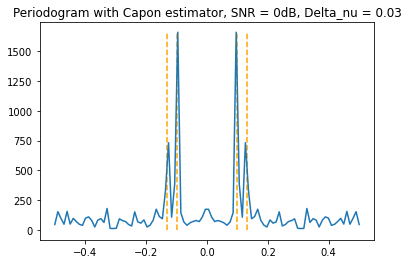

In [59]:
nu_plot = np.linspace(-0.5, 0.5, 100)
plt.plot(nu_plot, l2)
plt.title('Periodogram with Capon estimator, SNR = 0dB, Delta_nu = 0.03')
plt.vlines([-0.13, -0.1, 0.1, 0.13], 0, max(l2), colors='orange', linestyle='--')
plt.show()

In [60]:
%%time
s, noise = create_sinusoid(100, 2, [1,1], [0.4, 0.1], [0,0], sigma2=0.1)
l3 = periodogram_capon(s)

Wall time: 52.8 s


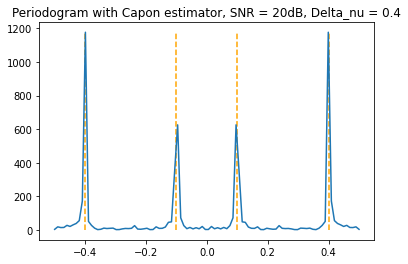

In [61]:
nu_plot = np.linspace(-0.5, 0.5, 100)
plt.plot(nu_plot, l3)
plt.title('Periodogram with Capon estimator, SNR = 20dB, Delta_nu = 0.4')
plt.vlines([-0.4, -0.1, 0.4, 0.1], 0, max(l3), colors='orange', linestyle='--')
plt.show()

In [62]:
%%time
s, noise = create_sinusoid(100, 2, [1,1], [0.4, 0.1], [0,0], sigma2=3)
l4 = periodogram_capon(s)

Wall time: 51.1 s


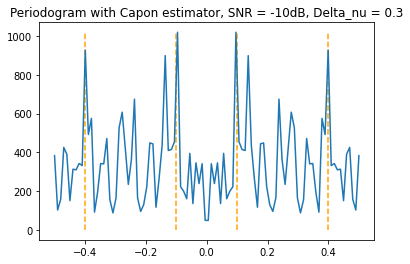

In [63]:
nu_plot = np.linspace(-0.5, 0.5, 100)
plt.plot(nu_plot, l4)
plt.title('Periodogram with Capon estimator, SNR = -10dB, Delta_nu = 0.3')
plt.vlines([-0.4, -0.1, 0.4, 0.1], 0, max(l4), colors='orange', linestyle='--')
plt.show()

In [ ]:
%%time
s, noise = create_sinusoid(100, 2, [1,1], [0.4, 0.1], [0,0], sigma2=10)
l5 = periodogram_capon(s)

In [ ]:
nu_plot = np.linspace(-0.5, 0.5, 100)
plt.plot(nu_plot, l5)
plt.title('Periodogram with Capon estimator, SNR = -20dB, Delta_nu = 0.3')
plt.vlines([-0.4, -0.1, 0.4, 0.1], 0, max(l5), colors='orange', linestyle='--')
plt.show()

The Capon estimator seems to give a very good spectral resolution, even when $\Delta \nu$ is as low as 0.03 (plot with 100 points between -0.5 and 0.5). The peaks are well separated, very thin, and stand above the noise of the periodogram. The smaller SNR for which the peaks remain separable seems to be -10dB. For -20dB for example, the peaks at $\nu_1$ and $\nu_2$ are no longer the major peaks of the periodogram. 

## 3 Autoregressive-moving-average process

In [28]:
def create_ARMA(N, ar_coeffs, ma_coeffs, sigma2 = 1):
    p,q = len(ar_coeffs), len(ma_coeffs)
    Z = np.random.normal(0, np.sqrt(sigma2), size=N)
    X = [0 for k in range(N)]
    for k in range(N):
        sum_ij = 0
        for i in range(p):
            sum_ij += ar_coeffs[i]*X[k-i-1]
        for j in range(q):
            sum_ij += ma_coeffs[j]*Z[k-j-1]
        X[k] = sum_ij + Z[k]
    return X

In [29]:
def create_ARMA11(N, ar_coeff, ma_coeff, sigma2=1):
    X = np.zeros(N)
    Z = np.random.normal(0, np.sqrt(sigma2), size=N)
    for k in range(1, N):
        X[k] = ar_coeff*X[k-1] + ma_coeff*Z[k-1] + Z[k]
    return X

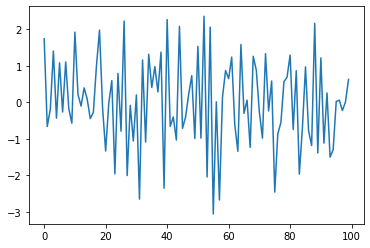

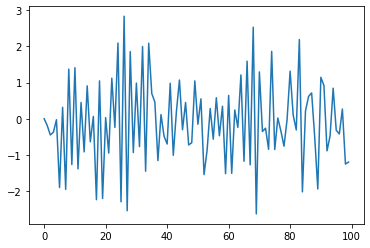

In [109]:
#Plot the ARMA Signals
arma = create_ARMA(100, [-0.9], [0.5])
plt.plot(np.arange(100),arma)
plt.show()
arma_11 = create_ARMA11(100, -0.9, 0.5)
plt.plot(np.arange(100),arma_11)
plt.show()

In [118]:
import spectrum.arma
from spectrum import arma2psd

In [114]:
def display_periodogram_arma(X, ar_coeffs, ma_coeffs, sigma2 = 1, method='std'):
    nu = np.linspace(-0.5, 0.5, 100)
    per = []
    known_psd = []
    p,q = len(ar_coeffs), len(ma_coeffs)
    for nu_k in nu:
        per.append(periodogram(X, nu_k))
        sum_a, sum_b = 1,1
        for i in range(1,q+1):
            sum_b += ma_coeffs[i-1]*np.exp(-2*1j*np.pi*nu_k*i)
        for j in range(1, p+1):
            sum_a -= ar_coeffs[j-1]*np.exp(-2*1j*np.pi*nu_k*j)
        known_psd.append(sigma2*(np.abs(sum_a)/np.abs(sum_b))**2)
    #per = per/max(per)
    plt.plot(nu, 20*np.log10(per), label=method)
    plt.plot(nu, 10*np.log10(arma2psd(np.array([-0.9]), np.array([0.6]), NFFT=100)), label='pyspectrum psd')
    
    plt.legend()
    plt.title(method)
    plt.show()
    if method == 'Welch':
        f, Pxx_den = signal.welch(X, window='bartlett', noverlap=0, nperseg=100, return_onesided=False)
        Pxx_den = Pxx_den/max(Pxx_den)
        Pxx_den = np.roll(Pxx_den, len(f)//2)
        plt.plot(np.roll(f,len(f)//2),10*np.log10(Pxx_den), label='Welch by scipy signal')
        plt.plot(nu, 10*np.log10(arma2psd(np.array([-0.9]), np.array([0.6]), NFFT=100)), label='pyspectrum psd')
        plt.legend()
        plt.title('Periodogram with Welch method from scipy signal')
        plt.show()

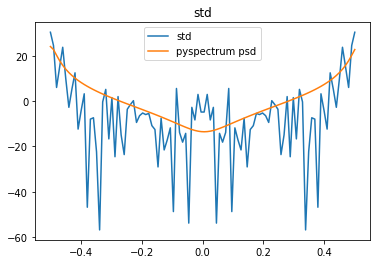

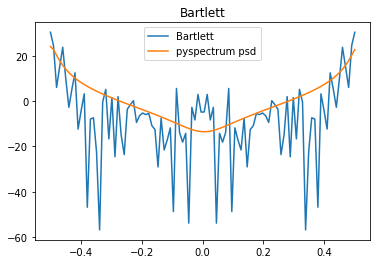

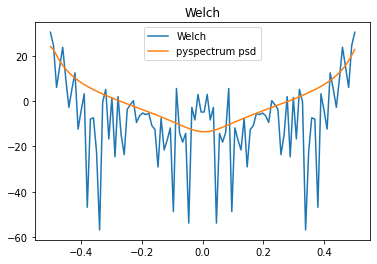

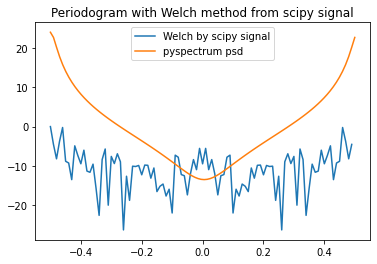

In [115]:
arma = create_ARMA(100, [-0.9], [0.5])
for method in methods: 
    display_periodogram_arma(arma, [0.7], [-0.5], method=method) 

The three periodograms coded by hand are close to the real one given by spectrum. However the periodogram from scipy signal looks further from the theoretical one given by pyspectrum.

### 3.3 Parametric estimation : Durbin method

In [116]:
def estimate_AR(signal, p, q):
    A = np.zeros((p,p))
    for line in range(p):
        for col in range(p):
            A[line,col] = r_xx(signal, q - col + line)
    vect = np.zeros(p)
    for row in range(p):
        vect[row] = r_xx(signal, q + row +1)
    estimated_coeff = np.linalg.inv(A) @ vect
    return estimated_coeff      

In [137]:
#test for ARMA (1,1)
estimate_AR(create_ARMA11(500, 0.7, 0.3), 1, 1)

array([0.71058328])

For an ARMA(1,1), the estimated coefficient is quite close. Let's test it for more coefficients

In [139]:
#Test for ARMA(3,3)
estimate_AR(create_ARMA(500, [0.7, 0.1, -0.5], [0.3, 0.8, -0.1]), 3, 3)

array([ 0.69955948,  0.07291683, -0.49737011])

The AR coefficients are also quite close to the real ones. This estimation function really looks to be working.

In [140]:
#First step is to compute A_L(nu)
def A_L(signal, q, nu):
    #First step is to compute 
    l = q*q + 10 # choose l, largely greater than q, we add 10 for small q
    est_coeffs = estimate_AR(signal, l, l)
    sum_A = 1
    for m in range(l):
        sum_A -= est_coeffs[m]*np.exp(-2*1j*np.pi*m*nu)
    return np.abs(sum_A)**2

#Then we compute the inverse Fourrier transform of A_L(nu) to obtain r_L(k)

def r_L(signal, q):
    nu = np.concatenate((np.linspace(0, 0.5, 512), np.linspace(-0.5, 0, 512)))
    #integral = 0
    #for k in range(1, len(nu)):
        #integral += A_L(signal, q, nu[k])*np.exp(2*1j*np.pi*nu[k]*k)*(nu[k]-nu[k-1])
    #return np.real(integral/(2*np.pi))
    a = A_L(signal, q, nu)
    return np.real(np.fft.ifft(a))

#Now we build the covariance matrix and the Yule walker equations

def get_q_ma_coeffs(signal, q):
    matrix = np.zeros((q,q))
    r = r_L(signal, q)
    for line in range(q):
        for col in range(q):
            matrix[line,col] = r[-col + line]
    vect = np.zeros(q)
    for row in range(q):
        vect[row] = r[row +1]
    estimated_coeff = np.linalg.inv(matrix) @ vect
    return estimated_coeff

In [178]:
%%time
r_L(s, 2)

Wall time: 77.2 ms


array([ 0.84940534, -0.18797907, -0.2878564 , ..., -0.03638073,
       -0.2878564 , -0.18797907])

In [179]:
%%time
get_q_ma_coeffs(s, 1)

Wall time: 46.4 ms


array([-0.61640258])

From Spectrum, the coefficients AR are 0.2293062805205287 and the MA coefficients are 0.14519713457559427
From Spectrum, the coefficients AR are 0.18678001949212364 and the MA coefficients are 0.077076192436024
From Spectrum, the coefficients AR are -0.2996317187960079 and the MA coefficients are -0.36873740470481614
From Spectrum, the coefficients AR are -0.1776902616333157 and the MA coefficients are -0.2629870320055617
From Spectrum, the coefficients AR are 0.002250188776292529 and the MA coefficients are -0.12039470967643585
#### Results by coded Durbin method
From our Durbin methodthe coefficients AR are -0.20061615425577564 and the MA coefficients are 0.011855931259915962
From our Durbin methodthe coefficients AR are 0.3698532330227882 and the MA coefficients are -0.04487071078290451
From our Durbin methodthe coefficients AR are 0.15933999663956505 and the MA coefficients are 0.016690231597789918
From our Durbin methodthe coefficients AR are 0.24127351287276472 and the MA coeffic

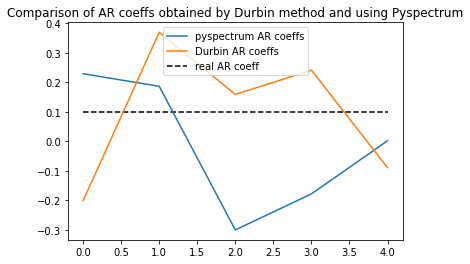

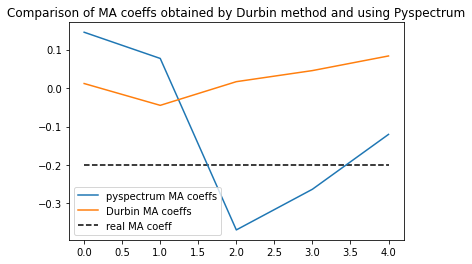

In [293]:
spec_coeffs_ar, spec_coeffs_ma = [], []
durbin_coeffs_ar, durbin_coeffs_ma = [], []
for i in range(5):
    a, b, rho = arma_estimate( np.array(create_ARMA(2000, [0.1], [-0.2])), 1, 1, lag=2)
    print(f'From Spectrum, the coefficients AR are {np.real(a)[0]} and the MA coefficients are {np.real(b[0])}')
    spec_coeffs_ar.append(np.real(a)[0])
    spec_coeffs_ma.append(np.real(b[0]))
print('#### Results by coded Durbin method')
for i in range(5):
    s = create_ARMA11(2000, 0.1, -0.2)
    a = estimate_AR(s, 1, 1)
    b = get_q_ma_coeffs(s, 1)
    durbin_coeffs_ar.append(a)
    durbin_coeffs_ma.append(b)
    print(f'From our Durbin methodthe coefficients AR are {np.real(a)[0]} and the MA coefficients are {np.real(b[0])}')
plt.plot(spec_coeffs_ar, label='pyspectrum AR coeffs')
plt.plot(durbin_coeffs_ar, label='Durbin AR coeffs')
plt.hlines([0.1], xmin=0, xmax=4, label='real AR coeff', linestyles='--', color='black')
plt.legend()
plt.title('Comparison of AR coeffs obtained by Durbin method and using Pyspectrum')
plt.show()

plt.plot(spec_coeffs_ma, label='pyspectrum MA coeffs')
plt.plot(durbin_coeffs_ma, label='Durbin MA coeffs')
plt.hlines([-0.2], xmin=0, xmax=4,label='real MA coeff', linestyles='--', color='black')
plt.legend()
plt.title('Comparison of MA coeffs obtained by Durbin method and using Pyspectrum')
plt.show()

Here, I used the arma_estimate function from pyspectrum to compare its results with Durbin method coded by hand. I was disappointed by my own results, but I see the results this functions outputs are not much better. Over five runs, there is not a real consistency the results.

In [334]:
#Comparison of the Periodograms
s = np.array(create_ARMA(2000, [0.1], [-0.2]))
ar = estimate_AR(s, 1, 1)
ma = get_q_ma_coeffs(s, 1)
print(ar,ma)
nu = np.linspace(-0.5, 0.5, 2000)

[0.14037142] [-0.21417496]


I admit have run the cell until I got a good result for the coeffs...

In [342]:
nu = np.linspace(-0.5, 0.5, 2000)
per = [periodogram(s, nu_k, method='Welch') for nu_k in nu]

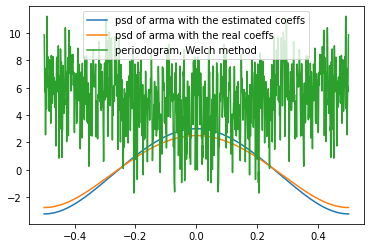

In [343]:
plt.plot(nu, 10*np.log10(arma2psd(np.array(ar), np.array(ma), NFFT=2000)), label='psd of arma with the estimated coeffs')
plt.plot(nu, 10*np.log10(arma2psd(np.array([0.1]), np.array([-0.2]), NFFT=2000)), label='psd of arma with the real coeffs')
plt.plot(nu, 10*np.log10(per), label='periodogram, Welch method')
plt.legend()
plt.show()

As expected, the two displayed PSDs are close, as I ran the cell a few times to get coefficients that were close to the real ones (randomness in each run comes from the noise variable when creating the ARMA signal). Although it seemed to work well in every parts of the lab before, my periodogram function displays a rather far estimation of the PSD.